# Estimate Diffusion Angle
---
This notebook estimates Noisy [1,2] parameters from Gaussian Random Fields movies. More specifically, the Adjoint method is used to estimate the opening angle of the diffusion tensor.

[1] https://github.com/AFD-Illinois/noisy

[2] https://github.com/aviadlevis/pynoisy

In [8]:
import pynoisy
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy as sci
from tqdm.notebook import tqdm
from scipy.optimize import minimize
import xarray as xr
from joblib import Parallel, delayed

## Forward Model

In [9]:
advection_true = pynoisy.advection.disk()
diffusion_true = pynoisy.diffusion.ring()
solver = pynoisy.forward.NoisySolver(advection_true, diffusion_true)
measurements = solver.run_symmetric(verbose=False)
measurements.to_netcdf('random_field_symetric.nc')

Synthetic measurements


<IPython.core.display.Javascript object>


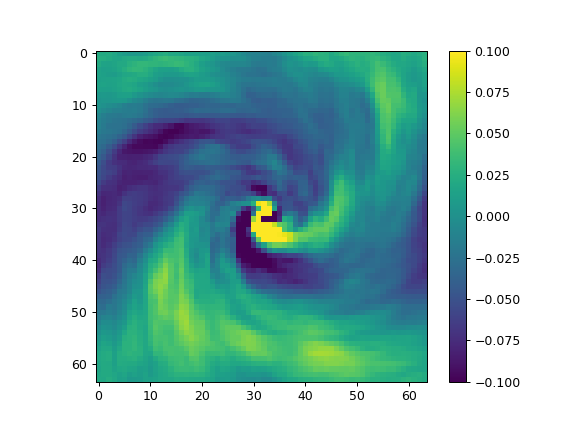

In [7]:
%matplotlib notebook
print('Synthetic measurements')
measurements.noisy_methods.get_animation(vmin=-0.1, vmax=0.1)

## Inverse Model (Fixed Known Noise)

In [10]:
"""
Load true random field generated previously
"""
measurements = xr.load_dataarray('random_field_symetric.nc')
advection_true = pynoisy.advection.disk()
diffusion_true = pynoisy.diffusion.ring()
solver = pynoisy.forward.NoisySolver(advection_true, diffusion_true)
solver.reseed(measurements.seed)

### Adjoint backpropogation

In [6]:
"""
Initilaize diffusion tensor angle with initial guess
"""
adjoint_solver = solver.copy()
adjoint_solver.set_diffusion(pynoisy.diffusion.ring(opening_angle=0.0))
adjoint_solver.reseed(measurements.seed)
random_field = adjoint_solver.run_symmetric()

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:41<00:00, 41.31s/it]


Initial guess


<IPython.core.display.Javascript object>


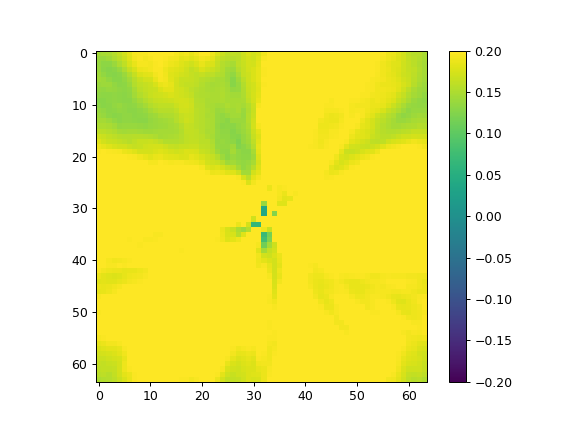

In [7]:
print('Initial guess')
%matplotlib notebook
random_field.noisy_methods.get_animation(vmin=-0.2, vmax=0.2)

In [8]:
"""
Compute error and backpropogate (Adjoint) error through Noisy
"""
error = random_field - measurements
adjoint_solver.set_advection(-solver.advection)
backprop = adjoint_solver.run_symmetric(source=error)

100%|██████████| 1/1 [00:27<00:00, 27.85s/it]


Error


<IPython.core.display.Javascript object>


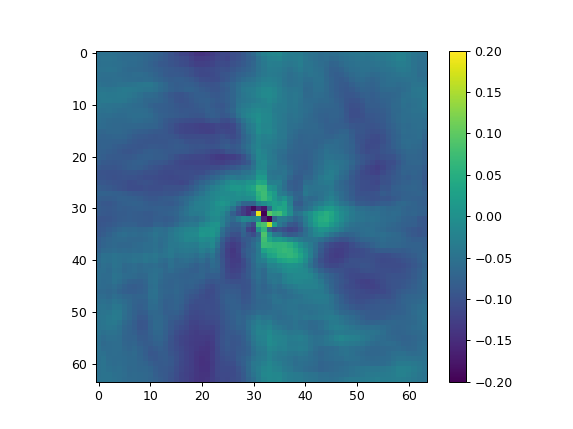

In [10]:
print('Error')
%matplotlib notebook
error.noisy_methods.get_animation(vmin=-0.2, vmax=0.2)

### Loss / gradient analysis

In [3]:
def objective_fun_adjoint(x, solver, measurements, dx=1e-2):
    solver.set_diffusion(pynoisy.diffusion.ring(opening_angle=x))
    random_field = solver.run_symmetric(verbose=False)
    error = random_field - measurements
    loss = (error**2).mean()

    solver.set_advection(-solver.advection)
    backprop = solver.run_symmetric(source=error, verbose=False)
    solver.set_advection(-solver.advection)

    solver.set_diffusion(pynoisy.diffusion.ring(opening_angle=x+dx))
    jac_source = solver.get_laplacian(measurements)
    solver.set_diffusion(pynoisy.diffusion.ring(opening_angle=x))
    jac_source -= solver.get_laplacian(measurements)
    jac_source = jac_source / dx

    gradient = (backprop * jac_source).mean()
    return np.array(loss), np.array(gradient)

def numerical_diffrentiation(x, solver, measurements, dx=1e-3):
    solver.set_diffusion(pynoisy.diffusion.ring(opening_angle=x))
    random_field = solver.run_symmetric(verbose=False)
    loss1 = ((random_field - measurements)**2).mean()
    
    solver.set_diffusion(pynoisy.diffusion.ring(opening_angle=x+dx))
    random_field = solver.run_symmetric(verbose=False)
    loss2 = ((random_field - measurements)**2).mean()
    
    numerical_gradient = (loss1 - loss2) / dx
    return np.array(numerical_gradient)

In [4]:
loss, grad, numerical_grad = [], [], []
theta_grid = np.linspace(0.0, 1.5*np.pi, 50)

# Compute adjoint differentiation
results = Parallel(n_jobs=50)(
    delayed(objective_fun_adjoint)(x, solver, measurements) for x in tqdm(theta_grid, desc='Adjoint diffrentiation')
)
loss, gradient = np.array(list(zip(*results)))

# Compute numerical differentiation
numerical_gradient = Parallel(n_jobs=50)(
    delayed(numerical_diffrentiation)(x, solver, measurements) for x in tqdm(theta_grid, desc='Numerical diffrentiation')
)

<IPython.core.display.Javascript object>


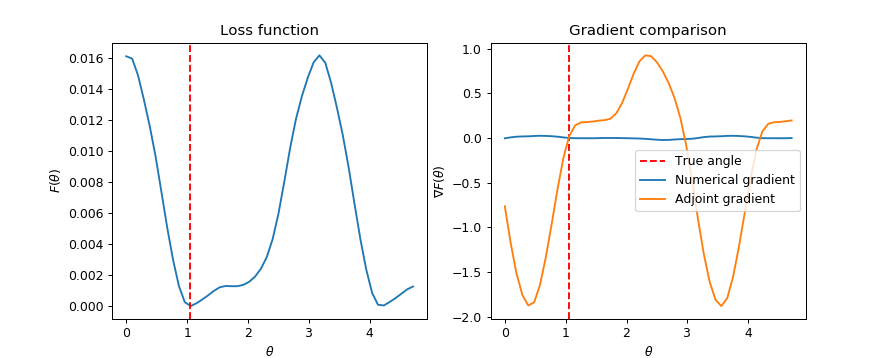

In [5]:
%matplotlib notebook 

fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].set_xlabel(r'$\theta$')
ax[0].set_ylabel(r'$F(\theta)$')
ax[0].set_title('Loss function')
ax[0].plot(theta_grid, loss, label='Loss')
ax[0].axvline(x=diffusion_true.opening_angle, label='True angle', color='r', linestyle='--')
ax[1].axvline(x=diffusion_true.opening_angle, label='True angle', color='r', linestyle='--')
ax[1].plot(theta_grid, numerical_gradient, label='Numerical gradient')
ax[1].plot(theta_grid, gradient, label='Adjoint gradient')
ax[1].set_xlabel(r'$\theta$')
ax[1].set_ylabel(r'$\nabla F(\theta)$')
ax[1].set_title('Gradient comparison')

plt.legend()

### Full Optimization

In [12]:
class OpeningAngleOptimizer(object):
    def __init__(self, solver, measurements):
        self._nfeval = 0
        self.solver = solver
        self.measurements = measurements
        
    def objective_fun(self, x):
        self.solver.set_diffusion(pynoisy.diffusion.ring(opening_angle=x))
        random_field = self.solver.run_symmetric(verbose=False)
        error = random_field - self.measurements
        loss = (error**2).mean()
        
        self.solver.set_advection(-self.solver.advection)
        backprop = self.solver.run_symmetric(source=error, verbose=False)
        self.solver.set_advection(-self.solver.advection)
    
        dx = 1e-2
        self.solver.set_diffusion(pynoisy.diffusion.ring(opening_angle=x+dx))
        jac_source = self.solver.get_laplacian(measurements)
        self.solver.set_diffusion(pynoisy.diffusion.ring(opening_angle=x))
        jac_source -= self.solver.get_laplacian(measurements)
        jac_source = jac_source / dx
        
        gradient = (backprop * jac_source).mean()

        return np.array(loss), np.array(gradient)

    def callback_fun(self, x):
        print('{}    {}'.format(self._nfeval, x))
        self._nfeval += 1
        
    def minimize(self, x0):
        result = minimize(fun=self.objective_fun, x0=np.array(x0), method='L-BFGS-B', jac=True)
        return result.x

In [13]:
"""
Optimization from many initial guesses. 
"""
optimizer = OpeningAngleOptimizer(solver, measurements)
x0_list = np.linspace(0.0, np.pi, 40)

results = Parallel(n_jobs=40)(
    delayed(optimizer.minimize)(x0) for x0 in tqdm(x0_list, desc='Optimization')
)

<IPython.core.display.Javascript object>


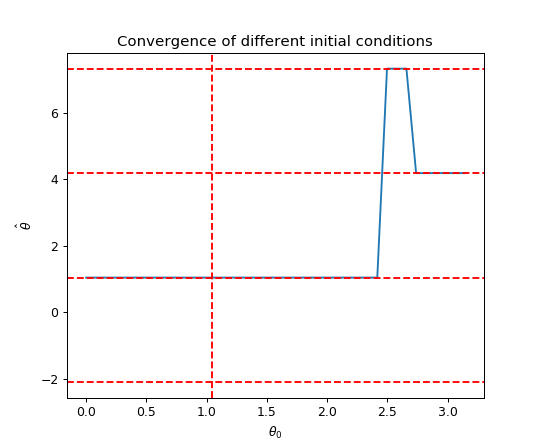

In [14]:
%matplotlib notebook
fig, ax = plt.subplots(1, 1, figsize=(6,5))
ax.set_xlabel(r'$\theta_0$')
ax.set_ylabel(r'$\hat{\theta}$')
ax.set_title('Convergence of different initial conditions')
ax.plot(x0_list, np.array(results))
plt.axhline(y=diffusion_true.opening_angle, color='r', linestyle='--')
plt.axhline(y=diffusion_true.opening_angle - np.pi, color='r', linestyle='--')
plt.axhline(y=diffusion_true.opening_angle + np.pi, color='r', linestyle='--')
plt.axhline(y=diffusion_true.opening_angle + 2*np.pi, color='r', linestyle='--')
plt.axvline(x=diffusion_true.opening_angle, color='r', linestyle='--')

## Inverse Model (Unknown Noise - Krylov)

In [15]:
class KrylovOpeningAngleOptimizer(object):
    def __init__(self, solver, measurements, degree=8):
        self._nfeval = 0
        self.solver = solver
        self.measurements = measurements
        self.degree = degree
        
    def objective_fun(self, x):
        self.solver.set_diffusion(pynoisy.diffusion.ring(opening_angle=x))
        random_field = self.solver.run_symmetric(verbose=False)
        error = self.compute_krylov_error()
        loss = (error**2).mean()
        
        self.solver.set_advection(-self.solver.advection)
        backprop = self.solver.run_symmetric(source=error, verbose=False)
        self.solver.set_advection(-self.solver.advection)
    
        dx = 1e-2
        self.solver.set_diffusion(pynoisy.diffusion.ring(opening_angle=x+dx))
        jac_source = self.solver.get_laplacian(measurements)
        self.solver.set_diffusion(pynoisy.diffusion.ring(opening_angle=x))
        jac_source -= self.solver.get_laplacian(measurements)
        jac_source = jac_source / dx
        
        gradient = (backprop * jac_source).mean()

        return np.array(loss), np.array(gradient)

    def get_krylov_matrix(self):
        k_matrix = []
        b = self.measurements.copy()
        for i in range(self.degree):
            b = self.solver.run_symmetric(source=b, verbose=False)
            k_matrix.append(np.array(b).ravel())
        return np.array(k_matrix)

    def compute_krylov_error(self):
        k_matrix = self.get_krylov_matrix()
        result = np.linalg.lstsq(k_matrix.T, np.array(self.measurements).ravel(), rcond=None)
        coefs, residual = result[0], result[1]
        rec = np.dot(coefs.T, k_matrix).reshape(*self.measurements.shape)
        error = rec - self.measurements
        return error
    
    def callback_fun(self, x):
        print('{}    {}'.format(self._nfeval, x))
        self._nfeval += 1
        
    def minimize(self, x0):
        result = minimize(fun=self.objective_fun, x0=np.array(x0), method='L-BFGS-B', jac=True)
        return result.x

In [16]:
# Generate synthetic measurements
advection_true = pynoisy.advection.disk()
diffusion_true = pynoisy.diffusion.ring()
solver = pynoisy.forward.NoisySolver(advection_true, diffusion_true)
measurements = solver.run_symmetric(verbose=True)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:05<00:00,  5.95s/it]


In [17]:
optimizer = KrylovOpeningAngleOptimizer(solver, measurements)

n_jobs = 30
x0_list = np.linspace(-np.pi/2, np.pi/2, 30)
results = Parallel(n_jobs=n_jobs)(
    delayed(optimizer.minimize)(x0) for x0 in tqdm(x0_list, desc='Optimization')
)

<IPython.core.display.Javascript object>


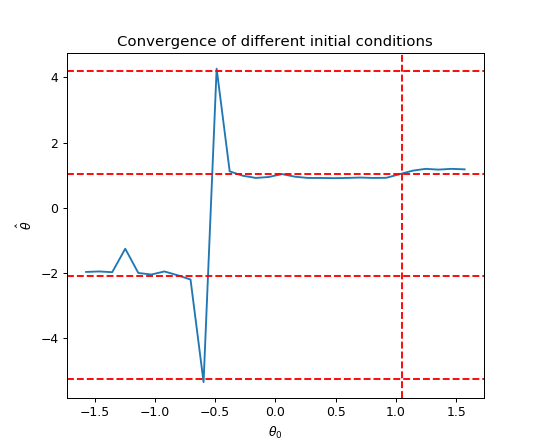

In [19]:
%matplotlib notebook
fig, ax = plt.subplots(1, 1, figsize=(6,5))
ax.set_xlabel(r'$\theta_0$')
ax.set_ylabel(r'$\hat{\theta}$')
ax.set_title('Convergence of different initial conditions')
ax.plot(x0_list, np.array(results))
plt.axhline(y=diffusion_true.opening_angle, color='r', linestyle='--')
plt.axhline(y=diffusion_true.opening_angle - np.pi, color='r', linestyle='--')
plt.axhline(y=diffusion_true.opening_angle + np.pi, color='r', linestyle='--')
plt.axhline(y=diffusion_true.opening_angle - 2*np.pi, color='r', linestyle='--')
plt.axvline(x=diffusion_true.opening_angle, color='r', linestyle='--')